# Week 4 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math
import zipfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2

#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [3]:
dfTrain

,vect,category
718,"[-0.3189430282859088, 0.3980829580556814]",0
613,"[0.4197999671650088, 0.30076304066079473]",1
61,"[0.7429477139000613, 0.5601032377144595]",1
591,"[0.3157716401899788, 0.7571530413102058]",1
901,"[-0.7622654076273571, -0.7059157571642074]",1
...,...,...
869,"[-0.582247408612978, -0.782888235305883]",1
114,"[0.9294372639761321, -0.10492061470858363]",0
207,"[-1.2628515736326098, -0.9218247867287767]",1
318,"[-0.18258577386371105, 0.82904505606615]",0


So, dfTrain has two columns, vect and category. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


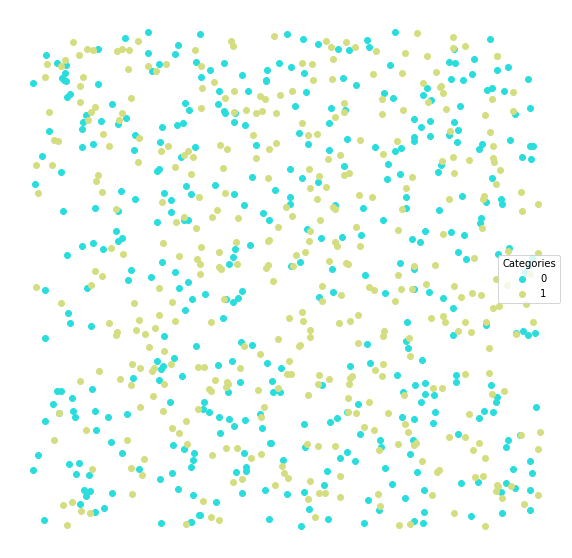

In [197]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

### Note on Naive Bayes
Notice That Naive Bayes treat every observation as independent and use Bayes Rule to deal with the data. That means when dealing with XOR types, they cannot factor in the "if x then not y" idea since x and y are independent. This justifies why it performs horribly in XOR data evaluation.

In [5]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [6]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [7]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

RandomForestClassifier()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [8]:
dfTrain['vect']

718     [-0.3189430282859088, 0.3980829580556814]
613     [0.4197999671650088, 0.30076304066079473]
61       [0.7429477139000613, 0.5601032377144595]
591      [0.3157716401899788, 0.7571530413102058]
901    [-0.7622654076273571, -0.7059157571642074]
                          ...                    
869      [-0.582247408612978, -0.782888235305883]
114    [0.9294372639761321, -0.10492061470858363]
207    [-1.2628515736326098, -0.9218247867287767]
318      [-0.18258577386371105, 0.82904505606615]
977    [-0.4354411280767137, -1.0452172810282996]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [9]:
np.stack(dfTrain['vect'])

array([[-0.31894303,  0.39808296],
       [ 0.41979997,  0.30076304],
       [ 0.74294771,  0.56010324],
       ...,
       [-1.26285157, -0.92182479],
       [-0.18258577,  0.82904506],
       [-0.43544113, -1.04521728]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [10]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.145,0.853781,0.872727,0.829791,0.864865
1,0.145,0.853781,0.833333,0.772247,0.842697


This lets us look at which classes do better:

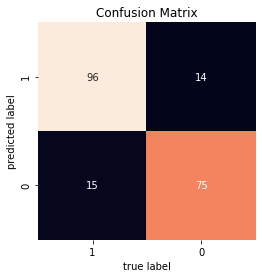

In [11]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

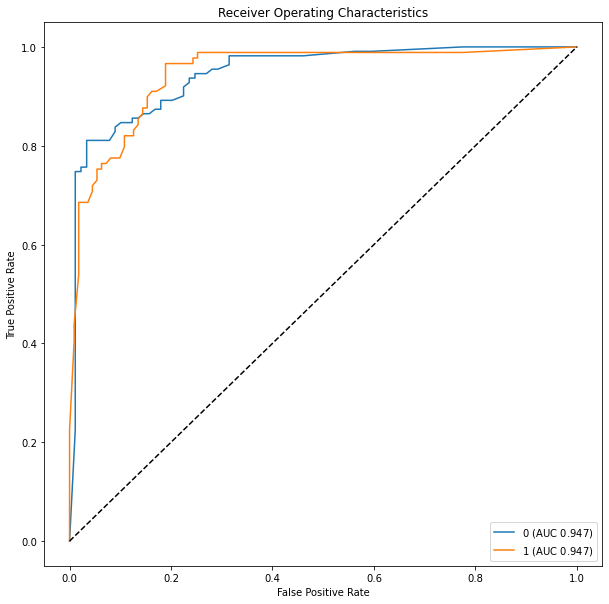

In [12]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


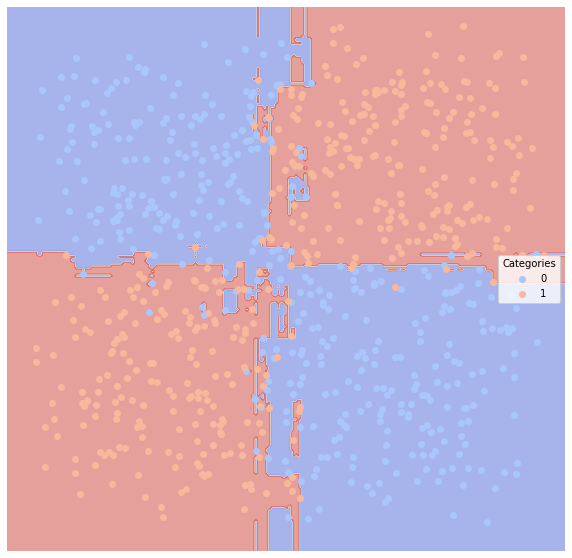

In [13]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [64]:
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [15]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [16]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

In [17]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.181818,0.715957,0.724138,0.493730,0.500000
Tales From Tech Support,0.053292,0.911350,0.944444,0.833619,0.839506
Bad Roommates,0.147335,0.774710,0.742424,0.554535,0.620253
Weeaboo Tales,0.175549,0.866776,0.577236,0.558989,0.946667


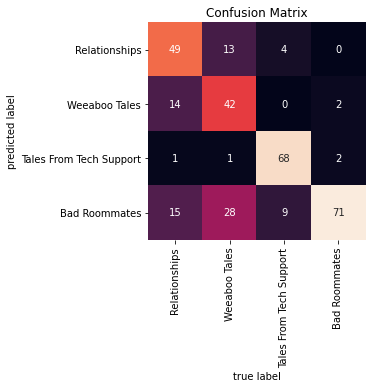

In [18]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

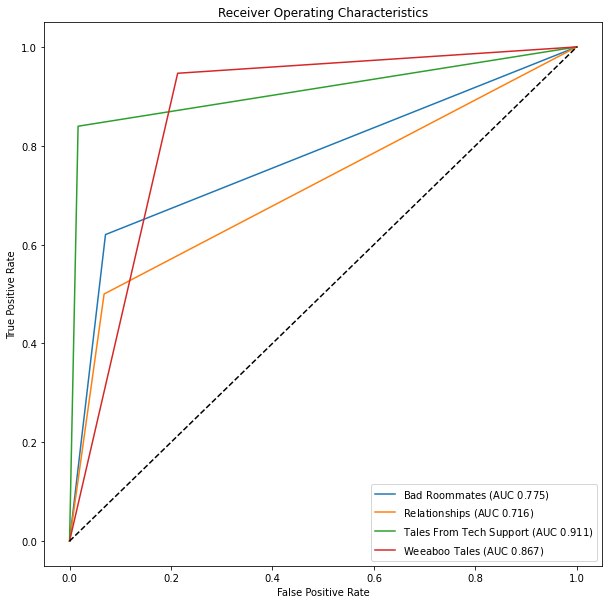

In [19]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

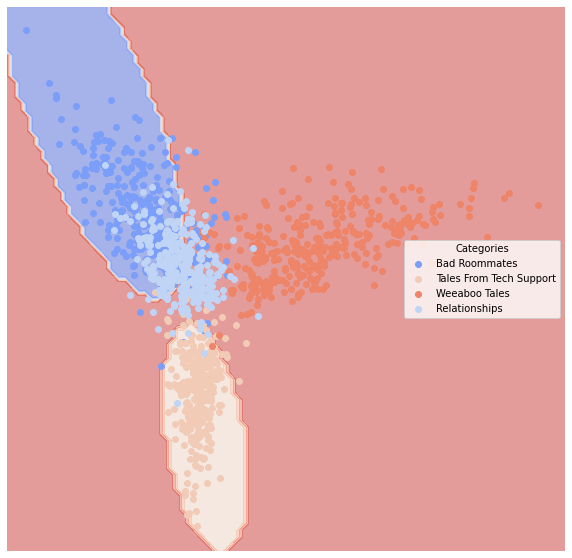

In [20]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

I performed all available methods, yet including all of them will waste too much block, thus I only keep the best performing one.

## 10 Artificial Datasets

In [2]:
# 1
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_nn, dfTest)

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.06,0.940376,0.921569,0.903954,0.959184
1,0.06,0.940376,0.959184,0.923954,0.921569


In this sample, neural network works best, though it makes sense that some other algorithms might work better. The important thing about XOR is that it cannot be separated by a single line, thus linear separator (perceptron) works poorly. Also Naive Bayes will work poorly because it treats different dimensions as independent, yet XOR means that one dimension's existence depend highly on the other.

In [3]:
# 2
noise = .9
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
clf_rf = sklearn.ensemble.RandomForestClassifier()
clf_rf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_rf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.44,0.560647,0.524752,0.499052,0.569892
1,0.44,0.560647,0.595960,0.568613,0.551402


When changing noise to .9, AUC dropped significantly. As noted above, this highly depends on the sample data, no specific method will always outperform others in XOR scenario. 

In [78]:
# 3
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
clf_bayes = sklearn.naive_bayes.GaussianNB()
clf_bayes.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_bayes, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.902375,0.919540,0.859600,0.869565
1,0.095,0.902375,0.893805,0.870873,0.935185


This is a better algorithm (along with linear perceptron) because of the inherent feature of the generated data. Since it is "andSplit", only one dimension will determine any observations feature. Therefore, a simple line split (perceptron) or a simple algorithm that takes only one observations' feature into account (Naive Bayes) will work better than all the other fancy algorithm that might pick up some unnecessary feature that will lead to lower AUC.

In [112]:
# 4
noise = .6
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
clf_dt = sklearn.tree.DecisionTreeClassifier()
clf_dt.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_dt, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.29,0.710337,0.73,0.667404,0.701923
1,0.29,0.710337,0.69,0.630937,0.718750


Once we try a higher noise, the advantage of capturing the "andSplit" feature drops, making Naive Bayes and perceptron not so appealing. However, since noise is relatively high, it's hard to see which one will perform better in one round of estimation, thus I presented the best AUC performance in this round.

In [125]:
# 5
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
clf_bayes = sklearn.naive_bayes.GaussianNB()
clf_bayes.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_bayes, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.14,0.861745,0.801724,0.785820,0.94898
1,0.14,0.861745,0.940476,0.843408,0.77451


Since "targetSplit" produces one type that is fully inside another type, we can have a clear statistical property of both dimensions. And since the 2 dimensions doesn't have a clear correlation, Naive Bayes works pretty well with this sample. Others like decision tree or random forest also works well because the relationship is relatively simple to capture with sequential queries. Classifier that will work very bad would be perceptron or polynomial, since it cannot produce a circle as decision boundary.

In [159]:
# 6
noise = .6
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_nn, dfTest)

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.305,0.695,0.678899,0.632385,0.74
1,0.305,0.695,0.714286,0.639286,0.65


This again reflects the fact that when noise is higher, there's no particular algorithm that will outperform another in one round. In general, Naive Bayes seems to work best, yet in this round neural network seems to work better.

In [172]:
# 7
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
clf_linear = sklearn.svm.SVC(kernel = 'linear', probability = True)
clf_linear.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_linear, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0


With low noise multiBlobs, if we are lucky, the data will all be perfectly separated. In this case, most classifiers can have perfect AUC. In fact, the worst performance will be with more sophisticated models, such as random forest or ensemble, as it might pick up some unnecessary features.

In [185]:
# 8
noise = .9
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_nn, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.010,0.982918,0.980392,0.957837,0.970874
1,0.008,0.990563,0.965909,0.956678,0.988372
2,0.078,0.882906,0.794118,0.685733,0.818182
3,0.044,0.939938,0.878505,0.819742,0.912621
4,0.032,0.939839,0.960396,0.878664,0.889908


With higher noise, we again cannot find a clear best algorithm for multiBlobs. Most importantly, except for cases like Random forest is always superior than Decision tree, we cannot find any superiority here. Since the data is still distributed in a certain fashion, simpler methods like linear or Naive Bayes still has its advantage.

In [198]:
# 9
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
clf_poly = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf_poly.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_poly, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.475,0.525,0.524752,0.513119,0.53
1,0.475,0.525,0.525253,0.513131,0.52


It is not surprising that random will lead to very low AUC since there's no specific pattern in the data. Therefore I picked the highest AUC in this round, yet I suspect this is a bit by change, and a different round will produce a different "best" algorithm.

In [209]:
#10
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()
clf_ensemble.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_ensemble, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.455,0.546617,0.574468,0.550441,0.514286
1,0.455,0.546617,0.518868,0.500397,0.578947


This is a confirmation of the previous claim. In this particular sample and this round, the best performing one is ensemble algorithm, not the poly.

## Real Datasets

In [210]:
# News Group
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [222]:
clf_nn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_nn, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.051064,0.954969,0.857143,0.838004,0.967742
comp.windows.x,0.029787,0.949384,0.961905,0.896523,0.909910
comp.sys.mac.hardware,0.068085,0.902609,0.897436,0.796399,0.840000
misc.forsale,0.051064,0.925631,0.898148,0.819663,0.881818


Neural Network can find hidden features by composing multiple layers of features. It makes sense that it works well, though others work well as well. The only 2 that are bad are knn and decision tree. This probably reflect the fact that News dataset cannot be simply dealt with a single sequence of queries, and the intracategory texts are not close in text sense.

In [223]:
# Senate small
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())

Loading senate data
Converting to vectors


In [237]:
clf_linear.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf_linear, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.0,1.0,1.0,1.0,1.0
Obama,0.0,1.0,1.0,1.0,1.0


This case is quite interesting, with a perfect AUC, meaning that there seems to be a very clear feature decision hyperplane that can separate Obama and Clinton case. Other works well but not that perfect, yet more reasonable. This raises the question whether linear SVM is generalizable, thus using 0.99 AUC of random forest or esemble might be more reasonable. Should look more into the case if we want to do research on this dataset.

In [238]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())

# The third dataset doesn't exist in this year's github, see the coding output below.

FileNotFoundError: [Errno 2] No such file or directory: '../data/grimmerPressReleases'

In [239]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

# The fourth dataset doesn't exist in this year's github, see the coding output below.

Loading Spam


FileNotFoundError: [Errno 2] No such file or directory: '../data/Spam_Data/20021010_spam.tar.bz2'

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [2]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [3]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [4]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [5]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [6]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [7]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [8]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [9]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [10]:
TFVects.shape

(1368, 11325)

We can save this in the dataframe to make things easier

In [13]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [17]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [20]:
train_data_df['pca'] = [r for r in reduced_data]

In [23]:
np.stack(train_data_df[train_data_df['category']]['pca'])

array([[-2.01639223e-02, -2.49544756e-02,  4.72714675e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19],
       [-1.26181267e-02,  2.41359762e-02, -2.00546138e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19],
       [-3.43126206e-02,  4.69680850e-03,  1.29378404e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19],
       ...,
       [ 2.19817141e-03,  2.71066414e-02, -1.96630121e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19],
       [-1.54475988e-02, -4.87707453e-03, -3.10322477e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19],
       [-1.06387502e-02,  2.44930213e-03, -3.38857035e-02, ...,
         1.78332605e-18,  2.90677504e-19,  1.27579765e-19]])

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


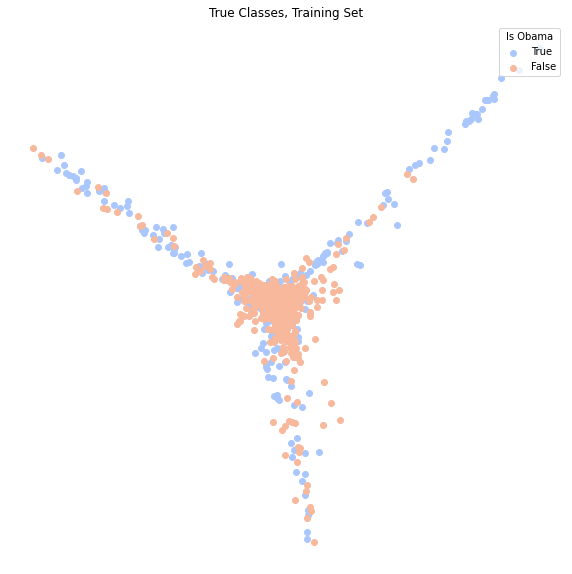

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

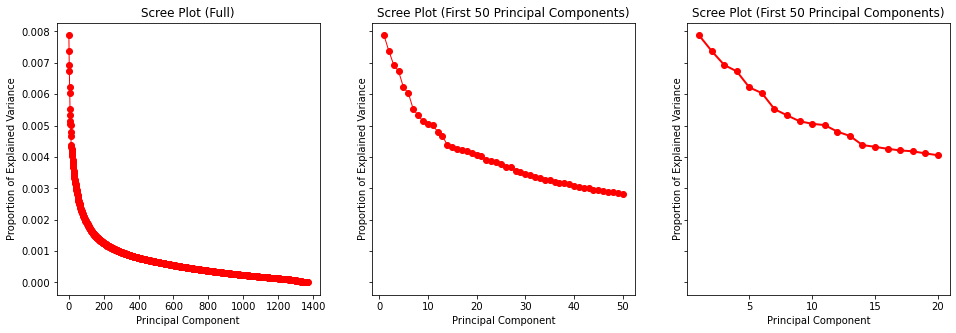

In [24]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [25]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [26]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [27]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.685672514619883

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [28]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6275659824046921

Slightly poorer. How about using more dimensions (40)?

In [29]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7331871345029239
Testing:
0.718475073313783


Or still more (100)?

In [30]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8084795321637427
Testing:
0.7653958944281525


Or even more (200)!

In [31]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8654970760233918
Testing:
0.8211143695014663


This is becoming ridiculous (400)!

In [32]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9042397660818714
Testing:
0.8299120234604106


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [35]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
# This is the l2 penalty, not l1?????
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9641812865497076


Train the model using training data, and then test it on the testing data.

In [37]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8387096774193549


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [38]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB()

In [39]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9495614035087719
Testing:
0.8592375366568915


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [40]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [41]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8837209302325582

Recall:

In [42]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.7755102040816326

F1-measure:

In [43]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.826086956521739

Let's take a look at how well our posterior distribution looks relative to the truth.

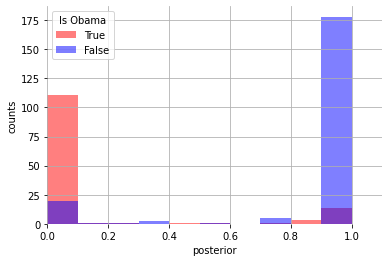

In [91]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [44]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.161963,labolt,-1.729884
1,announcement,-2.300113,5566,-1.739934
2,awarded,-2.312535,amy,-1.791759
3,island,-2.325114,brundage,-1.857717
4,read,-2.350757,dick,-1.869146
5,welcomed,-2.350757,affairs,-1.978345
6,urging,-2.390497,chicago,-1.978345
7,urban,-2.404103,location,-2.130362
8,construction,-2.417896,temporary,-2.160667
9,growing,-2.417896,cases,-2.240710


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [66]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [67]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [68]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [49]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [50]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [51]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [52]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB()

...and save predictions to the dataframe:

In [53]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.893789901334881


In [54]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1954,comp.graphics,comp.graphics
665,soc.religion.christian,soc.religion.christian
614,soc.religion.christian,soc.religion.christian
34,talk.religion.misc,talk.religion.misc
1131,sci.space,sci.space
132,talk.religion.misc,soc.religion.christian
922,soc.religion.christian,soc.religion.christian
1887,comp.graphics,comp.graphics
1549,sci.space,sci.space
1285,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [55]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.786046511627907


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

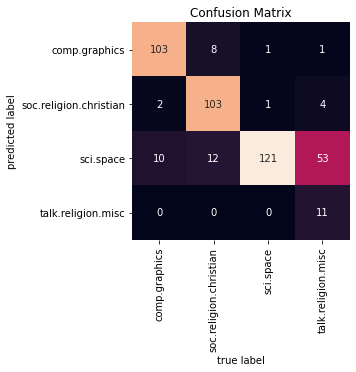

In [56]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [61]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8486730455620292
0.786046511627907
0.7556642667799904


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [62]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.051163,0.931953,0.911504,0.844298,0.895652
soc.religion.christian,0.179070,0.869720,0.617347,0.611960,0.983740
sci.space,0.062791,0.907299,0.936364,0.830621,0.837398
talk.religion.misc,0.134884,0.579710,1.000000,0.294304,0.159420


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

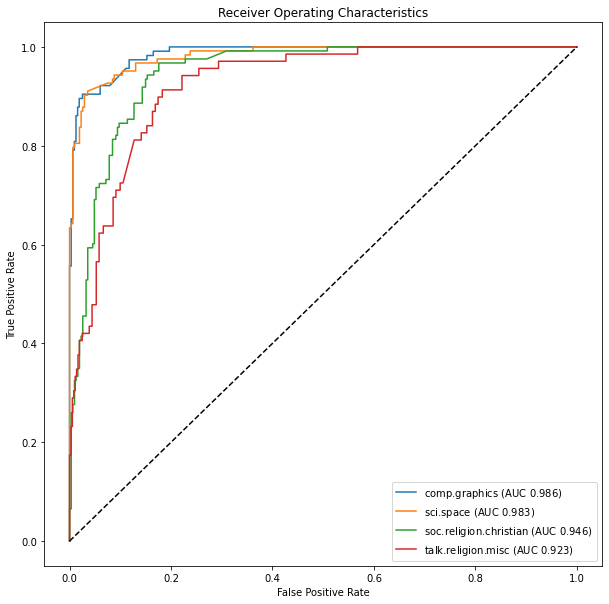

In [63]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

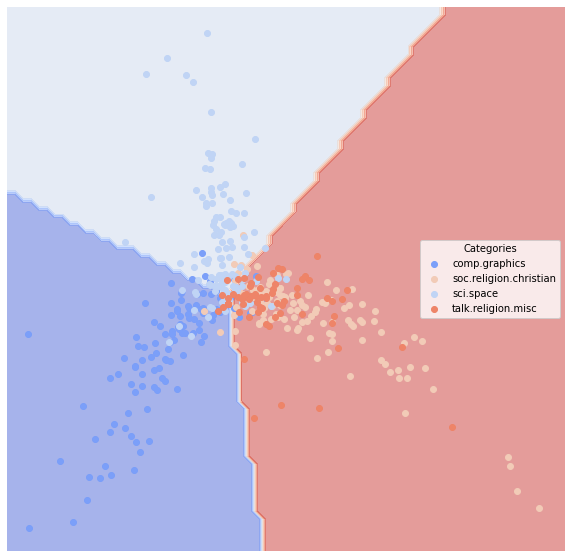

In [64]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


I aim to analyze whether different academic fields exhibit different ideology. For example, UChicago Economics in the 60,70s should be very liberal comparing to different social science fields. In doing so, we might shed light on whether it is "ideology" leading "scientific results", or as social scientests we are really trying to get scientific truth free from ideology.

In this case, I will start by classifying academic papers from the 2013-2015.

In [4]:
zfile = zipfile.ZipFile("/Users/yslin624/Dropbox/Content Analysis/data/COCA/sources.zip")
source = []

for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

# Filter first for 2013-2015 data
source_target = []
for data in source[3:]:
    try:
        tid, total_words, year, genre, subgenre, source, title, pubinfo = data.decode("utf-8").split("\t")
    except ValueError:
        try: 
            tid, total_words, year, genre, subgenre, source, title = data.decode("utf-8").split("\t")
        except UnicodeDecodeError:
            continue
    
    if np.logical_and(int(year) >= 2013, int(year) <= 2015):
        source_target.append(data)
        

In [5]:
# Filter for academic paper in 2013-2015, the observation number seems reasonable for this homework
source_acad =[]
for data in source_target:
    try:
        tid, total_words, year, genre, subgenre, source, title, pubinfo = data.decode("utf-8").split("\t")
    except ValueError:
        try: 
            tid, total_words, year, genre, subgenre, source, title = data.decode("utf-8").split("\t")
        except UnicodeDecodeError:
            continue
    if genre == 'ACAD':
        source_acad.append(data)

In [6]:
# Try to construct the dataset from COCA academic, which can be used in exercise 2-5
corpus_path =  '/Users/yslin624/Dropbox/Content Analysis/data/COCA'
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            #print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                #print(file)
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

# Creating raw text file and filter to our needs.
coca_raw = loadcorpus(corpus_path)
acad_text = coca_raw['2013_acad.txt'] + coca_raw['2014_acad.txt'] + coca_raw['2015_acad.txt']


In [7]:
# Do the data cleaning that was done in week 2
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            print("Unicode Error, Skip")
            continue
    return clean_texts
acad_text = clean_raw_text(acad_text)

In [8]:
acad_df = pandas.DataFrame({'id':[], 'text':[]})

# This is a very artificial data preperation, to help us merge with source data later.
def id_separation(text):
    identity = text[2:10]
    real_text = text[10:]
    acad_df.loc[len(acad_df)] = [identity, real_text]
    return acad_df

for text in acad_text:
    acad_df = id_separation(text)

In [9]:
# Tokenize and normalize to better classify
acad_df['tokenized_text'] = acad_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
acad_df['normalized_text'] = acad_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [10]:
# Merge this data with source data to start categorizing
source_df = pandas.DataFrame(columns = ['tid', 'total_words', 'year', 'genre', 'subgenre', 'source', 'title', 'pubinfo'])
for data in source_acad:
    try:
        tid, total_words, year, genre, subgenre, source, title, pubinfo = data.decode("utf-8").split("\t")
        source_df.loc[len(source_df)] = [tid, total_words, year, genre, subgenre, source, title, pubinfo]
    except ValueError:
        try: 
            tid, total_words, year, genre, subgenre, source, title = data.decode("utf-8").split("\t")
            source_df.loc[len(source_df)] = [tid, total_words, year, genre, subgenre, source, title, 0]
        except UnicodeDecodeError:
            continue
    
acad_df['id'] = acad_df['id'].apply(lambda x: int(x.strip("0")))
source_df['tid'] = source_df['tid'].apply(lambda x: int(x))
analyze_df = acad_df.merge(source_df, left_on = 'id', right_on = 'tid')

## Categorization

We need to investigate the different classification groups and then do a bit of data cleaning. 

In [14]:
# Investigating different genre.
list(analyze_df.subgenre.unique())

['148', '152', '151', '145', '147', 'NULL', '144', '150', '149', '146']

In [15]:
# By investigating different subgenre code, I manually code the corresponding category name.
# There is a special categorization in COCA, yet I cannot seem to find the right categorization code.
category_dict = {'148': 'Humanities', '152': 'Education', '151': 'Medicine',
                 '145': 'Librarian', '147': 'Law/Pol', '144': 'Geo/Sosc', 
                 '150': 'Sci/Tech', '149': 'Phil/Rel', 'NULL': 'Misc',
                 '146': 'Geo/Sosc'}

analyze_df['category'] = analyze_df['subgenre'].apply(lambda x: category_dict[x])

In [16]:
# Data split
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(analyze_df, holdBackFraction=holdBackFraction)

In [17]:
# Pick relevant tokens.
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

## Logistic Regression

In [18]:
# Set up text as vectors and do principal component analysis to do logistic regression efficiently
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

In [19]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.630122405534859

In [20]:
# Test this model on the test data
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.5842217484008528

The weird thing here is that we have a higher test data score, raising the probability that we did not include enough principal component in this round, thus we try to incorporate more component in the following rounds.

In [21]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.690792974986695
Testing:
0.6396588486140725


In [22]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.7461415646620543
Testing:
0.6886993603411514


In [23]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.7738158594997339
Testing:
0.7036247334754797


By altering the included principal component, we start getting more reasonable results. This is intuitive since in the previous ObamaClinton example, there's only 2 senator speaking, while in this dataset, different categories are written by different people.

## Multinomial NB

In [24]:
holdBackFraction = .2
train_df, test_df = lucem_illud.trainTestSplit(analyze_df, holdBackFraction=holdBackFraction)


In [25]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_df['text'])
train_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [26]:
MultinomialNB = sklearn.naive_bayes.MultinomialNB()
MultinomialNB.fit(np.stack(train_df['vect'], axis = 0), train_df['category'])
train_df['nb_predict'] = MultinomialNB.predict(np.stack(train_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB.score(np.stack(train_df['vect'], axis=0), train_df['category']))

Training score:
0.7376263970196913


In [27]:
# Test this Multinomial Model on Test data
#Create vectors
TFVects_test = TFVectorizer.transform(test_df['text'])
test_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_df['nb_predict'] = MultinomialNB.predict(np.stack(test_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB.score(np.stack(test_df['vect'], axis=0), test_df['category']))

Testing score:
0.6929637526652452


The discrepancy between training and testing is much wider than example, which make sense as this dataset is much more diverse. Yet we can still get a better than random testing score, which is quite reassuring that we can probably improve our result if we enhance the magnitude of dataset.

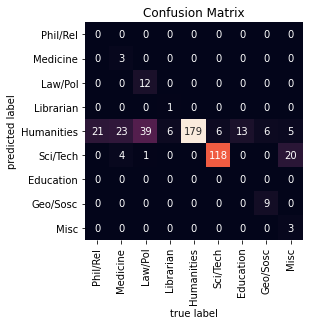

In [28]:
lucem_illud.plotConfusionMatrix(MultinomialNB, test_df)

This confusion matrix shows us that the dataset is highly skewed toward Misc (given that the provided package is really designed to randomly select between categories.) However, it is quite amazing testing on this data, we can still get a nice result.

In [29]:
print('Precision:')
print(sklearn.metrics.precision_score(test_df['category'], test_df['nb_predict'], average = 'weighted')) #precision
print('Recall:')
print(sklearn.metrics.recall_score(test_df['category'], test_df['nb_predict'], average = 'weighted')) #recall
print('F1-measure:')
print(sklearn.metrics.f1_score(test_df['category'], test_df['nb_predict'], average = 'weighted')) #F-1 measure


Precision:
0.7288738007459834
Recall:
0.6929637526652452
F1-measure:
0.6126241195342508


/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB, test_df)


/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Medicine,0.066098,0.939575,0.825175,0.798040,0.951613
Misc,0.027719,0.500000,0.000000,0.027719,0.000000
Humanities,0.085288,0.615385,1.000000,0.316057,0.230769
Librarian,0.253731,0.794828,0.600671,0.600671,1.000000
Law/Pol,0.012793,0.571429,1.000000,0.155650,0.142857
Phil/Rel,0.012793,0.800000,1.000000,0.612793,0.600000
Sci/Tech,0.053305,0.553571,1.000000,0.160448,0.107143
Education,0.044776,0.500000,0.000000,0.044776,0.000000
Geo/Sosc,0.057569,0.550000,1.000000,0.157569,0.100000


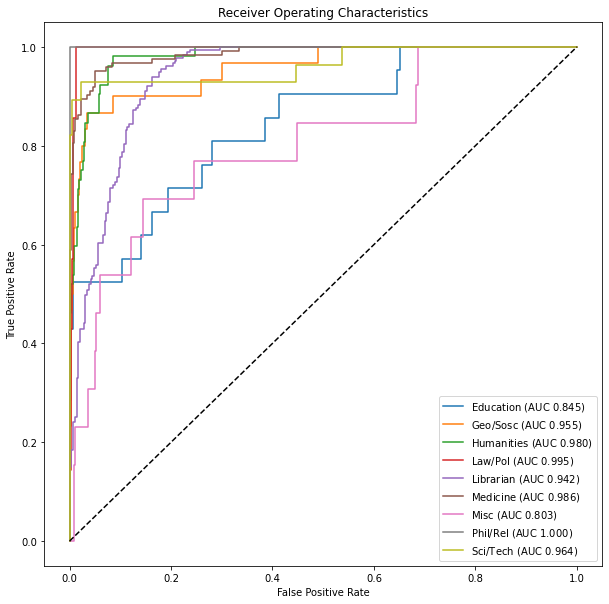

In [31]:
lucem_illud.plotMultiROC(MultinomialNB, test_df)

The result of this AUC, precision, F1, and recall is probably highly dependent on the different sample size of different category. Which help us understand that we probably should do a reasonable weighting on the sample before analyzing.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

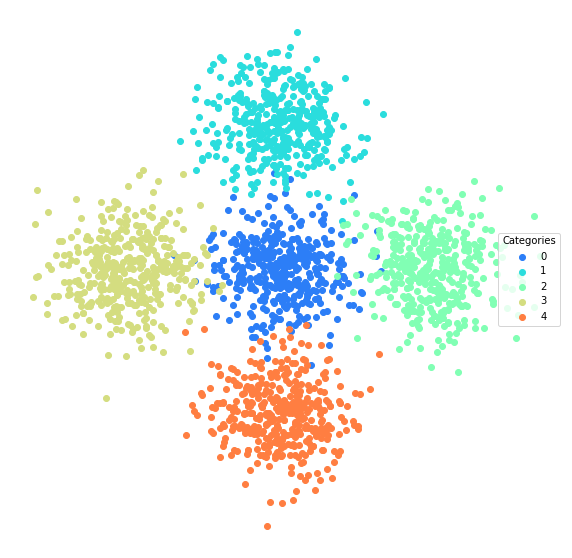

In [32]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [33]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

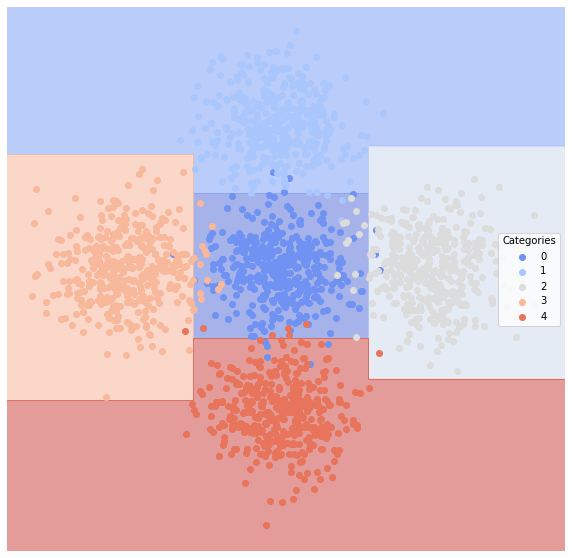

In [34]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [35]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.961247,0.904255,0.864019,0.944444
1,0.010,0.981009,0.990909,0.963833,0.964602
2,0.010,0.978348,0.989474,0.957087,0.959184
3,0.004,0.989362,1.000000,0.982723,0.978723
4,0.012,0.988909,0.954128,0.947042,0.990476


Lets look at accuracy:

In [36]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.968

What happens if we trim the tree?

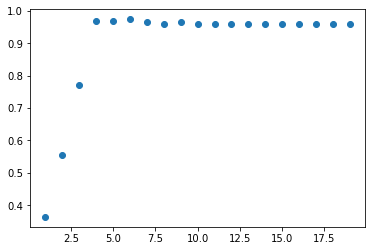

In [37]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [38]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) # Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [39]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

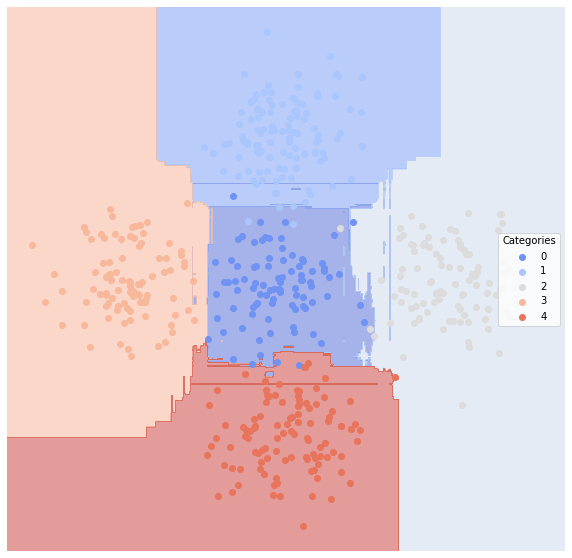

In [41]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [42]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.962466,0.913978,0.873202,0.944444
1,0.010,0.981009,0.990909,0.963833,0.964602
2,0.010,0.978348,0.989474,0.957087,0.959184
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.006,0.996203,0.972222,0.972222,1.000000


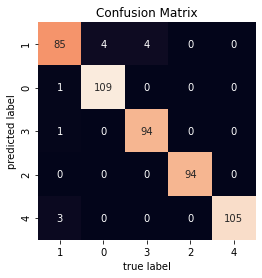

In [43]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

## Decision Tree

In [53]:
# Data Preperation
train_df, test_df = lucem_illud.trainTestSplit(analyze_df)
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_df['text'])
train_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]


In [54]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_df['vect'], axis =0), train_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

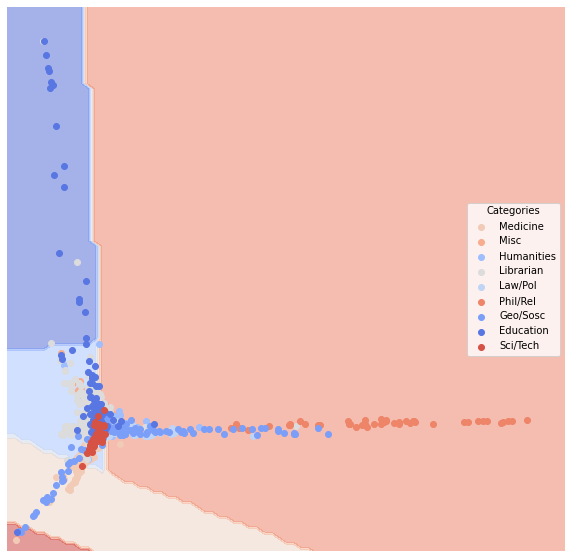

In [55]:
lucem_illud.plotregions(clf_tree, train_df)

In [57]:
sklearn.metrics.accuracy_score(test_df['category'],clf_tree.predict(np.stack(test_df['vect'], axis = 0)))

0.26865671641791045

In [56]:
lucem_illud.evaluateClassifier(clf_tree, test_df)

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Medicine,0.334755,0.484416,0.150000,0.301654,0.020979
Misc,0.038380,0.500000,0.000000,0.038380,0.000000
Humanities,0.162047,0.474638,0.000000,0.117271,0.000000
Librarian,0.650320,0.488226,0.301235,0.302121,0.847222
Law/Pol,0.023454,0.500000,0.000000,0.023454,0.000000
Phil/Rel,0.053305,0.488987,0.000000,0.031983,0.000000
Sci/Tech,0.085288,0.503605,0.076923,0.062354,0.034483
Education,0.063966,0.500000,0.000000,0.063966,0.000000
Geo/Sosc,0.051173,0.500000,0.000000,0.051173,0.000000


Unsurprisingly, decision tree performed not very well, even worse than random. This is a very diverse dataset, thus it might be better using random tree, instead of just trusting one decision tree, many trees applying majority rule voting might work better.

## Random Forest

In [58]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) # Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [59]:
bag.fit(np.stack(train_df['vect'], axis =0), train_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

Notice that this ensemble method is very time consuming as it needs to run through 100 decision trees. Even testing will take a lot of time as we need to run through the 100 trees for the final result.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

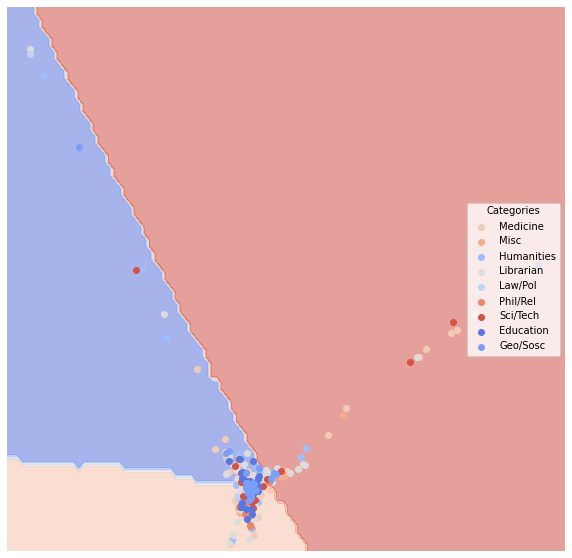

In [60]:
lucem_illud.plotregions(bag, test_df)

In [61]:
lucem_illud.evaluateClassifier(bag, test_df)

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Medicine,0.394456,0.478764,0.255814,0.297352,0.153846
Misc,0.051173,0.493348,0.000000,0.038380,0.000000
Humanities,0.176972,0.497716,0.111111,0.116823,0.072727
Librarian,0.565032,0.487885,0.299003,0.302016,0.625000
Law/Pol,0.027719,0.497817,0.000000,0.023454,0.000000
Phil/Rel,0.055437,0.487885,0.000000,0.031983,0.000000
Sci/Tech,0.095949,0.514028,0.100000,0.064466,0.068966
Education,0.063966,0.500000,0.000000,0.063966,0.000000
Geo/Sosc,0.057569,0.536049,0.285714,0.070718,0.083333


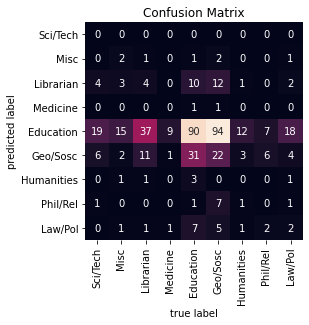

In [62]:
lucem_illud.plotConfusionMatrix(bag, test_df)

In general, random forest doesn't seem to work well on the academic classification. This might be due to the fact that lots of feature and words are extremely sparse, thus hard to find clear cut decision boundaries to divide the feature space. This may also stem from the relationship between different dimensions, like when viewing the plot region, it seems natural that different cases cannot be classified by rectangular regions.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [69]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [70]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [71]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [72]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [73]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [74]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.277423,0.600556,0.481481,0.341101,0.334764
comp.graphics,0.467789,0.563453,0.321888,0.304713,0.632911
talk.religion.misc,0.232153,0.694074,0.405345,0.311390,0.577778
soc.religion.christian,0.261172,0.519231,1.000000,0.299634,0.038462


And lets look at the testing data

In [75]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.25813953488372093


Let's produce another confusion matrix:

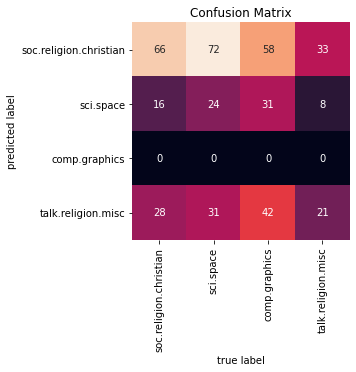

In [76]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

I will ignore the last question since we have not covered k-means clustering in week 3.

In [77]:
# Data Preperation
train_df, test_df = lucem_illud.trainTestSplit(analyze_df)
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_df['text'])
train_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [78]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [79]:
clf_knearest.fit(np.stack(train_df['vect'], axis = 0), train_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [80]:
lucem_illud.evaluateClassifier(clf_knearest, train_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Medicine,0.045237,0.946284,0.911488,0.865358,0.927203
Misc,0.025546,0.622401,0.882353,0.241453,0.245902
Humanities,0.055349,0.927055,0.704626,0.648236,0.904110
Librarian,0.106972,0.892890,0.819193,0.768854,0.892424
Law/Pol,0.005854,0.862500,1.000000,0.730854,0.725000
Phil/Rel,0.002129,0.989564,0.944444,0.926814,0.980769
Sci/Tech,0.013837,0.893104,0.953488,0.763497,0.788462
Education,0.043108,0.680096,0.769231,0.319008,0.366972
Geo/Sosc,0.025546,0.881885,0.790909,0.627672,0.776786


In [81]:
# Check testing data
#Add to df
test_df['nb_predict'] = clf_knearest.predict(np.stack(test_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_df['vect'], axis=0), test_df['category']))

Testing score:
0.22174840085287847


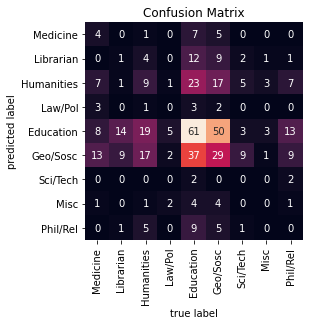

In [82]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_df)

Surprisingly, knn works well in a train case even when we have a very high dimension data (though limited to k = 15). This probably means that the most important or frequent words are sufficient to classify our data. However, it works poorly on testing data, I highly suspect this is because of the nonrandomness or different proportion chosen by the provided package. Therefore, when actually conducting final project or research, it might be better to find another way to sample and divide the test and training data.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [83]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [84]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [85]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [86]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [87]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.018809,0.974545,0.961538,0.933961,0.961538
Tales From Tech Support,0.009404,0.993776,0.962963,0.962963,1.000000
Relationships,0.025078,0.965949,0.966292,0.928873,0.945055
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003135,0.993056,1.000000,0.989246,0.986111


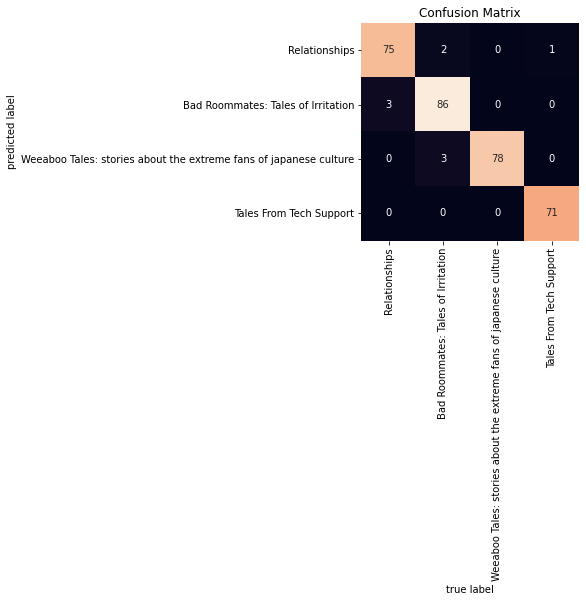

In [88]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

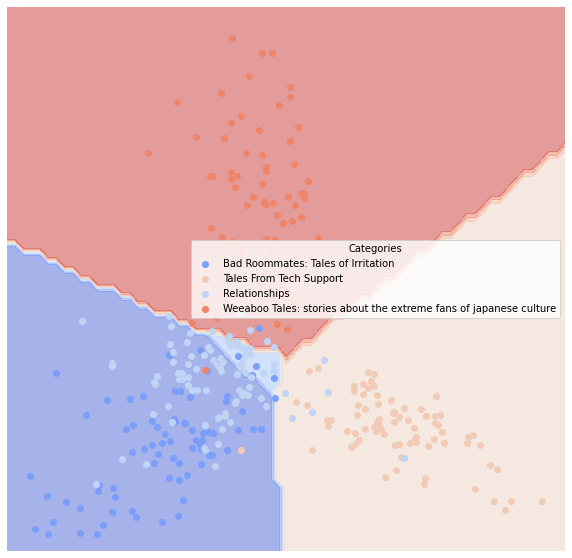

In [89]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [90]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [91]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.028213,0.963986,0.936709,0.901212,0.948718
Tales From Tech Support,0.009404,0.993776,0.962963,0.962963,1.000000
Relationships,0.031348,0.954960,0.965517,0.913190,0.923077
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.991031,0.986111,0.975550,0.986111


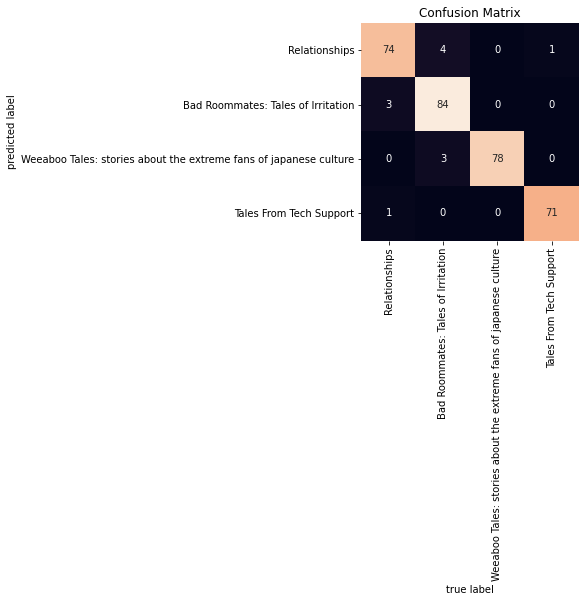

In [92]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

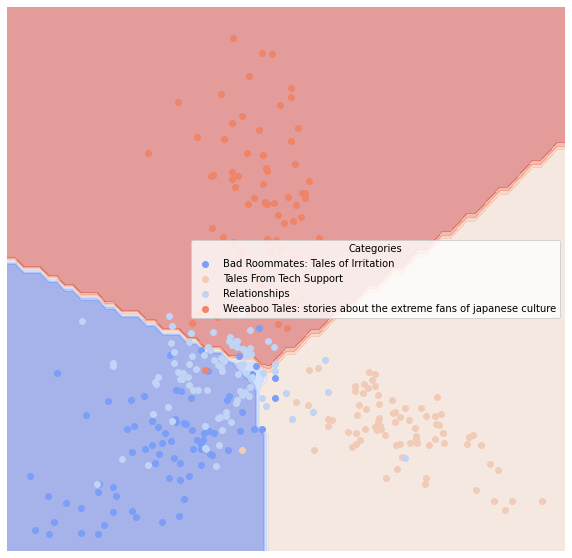

In [93]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [94]:
#tokenize and normalize
analyze_df['tokenized_text'] = analyze_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
analyze_df['normalized_text'] = analyze_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [95]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform([' '.join(l) for l in analyze_df['normalized_text']])
analyze_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [96]:
# Data Preperation
holdBackFraction = .2
train_df, test_df = lucem_illud.trainTestSplit(analyze_df, holdBackFraction=holdBackFraction)

In [97]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_df['vect'], axis=0), train_df['category'])

MLPClassifier()

In [98]:
lucem_illud.evaluateClassifier(clf_nn, test_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Medicine,0.025586,0.974919,0.931298,0.915343,0.976000
Misc,0.023454,0.686396,0.857143,0.342751,0.375000
Humanities,0.025586,0.962318,0.854839,0.815440,0.946429
Librarian,0.083156,0.920911,0.852632,0.821872,0.936416
Law/Pol,0.006397,0.856061,0.833333,0.599502,0.714286
Phil/Rel,0.000000,1.000000,1.000000,1.000000,1.000000
Geo/Sosc,0.023454,0.822724,0.833333,0.560536,0.652174
Education,0.036247,0.763587,0.736842,0.422347,0.538462
Sci/Tech,0.014925,0.897059,1.000000,0.809043,0.794118


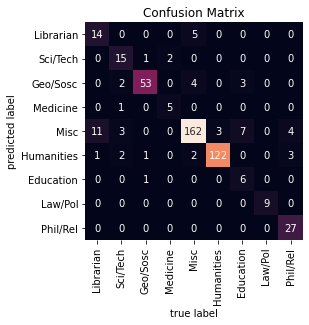

In [99]:
lucem_illud.plotConfusionMatrix(clf_nn, test_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

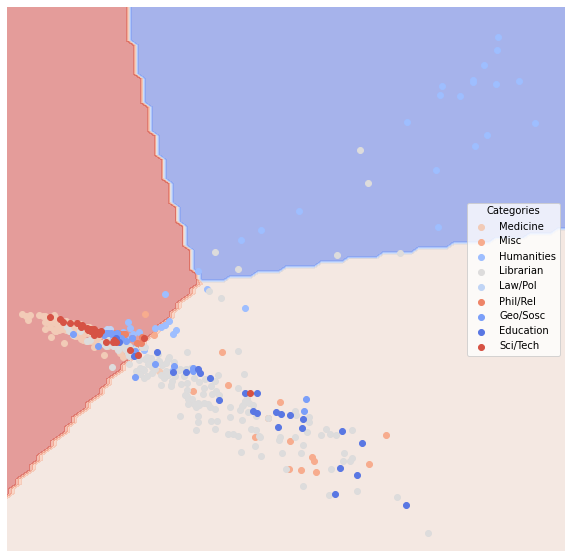

In [100]:
lucem_illud.plotregions(clf_nn, test_df)

Unsurprisingly, neural network works very well comparing to the other methods. This is probably due to its ability to uncover some hidden features, since for academic texts it might not be very clear cut which words or frequency corresponds to a certain category. By adding multiple layer to the decision structure, we can obtain a fairly convinving result. Therefore, if I need to use classification in the final project, neural network will probably be my first choice.